# Imports & Loading the Titanic Data

In [25]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split

# set file path
filepath = "data/titanic-grid-search/"

# Load train and test datasets
titanic_train_df = pd.read_csv(filepath + 'titanic-train.csv')
titanic_test_df = pd.read_csv(filepath + 'titanic-test.csv')
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing and Exploring the Data

In [26]:
# Define a function for preprocessing the train and test data 
def preprocess(dfx):
    df = dfx.copy()
    
    # Deleting some columns from the data
    new_df = df[df.columns[~df.columns.isin(['Survived', 'Cabin', 'PassengerId', 'Name', 'Ticket'])]].copy()
    
    # Replace missing values
    new_df.fillna(df.mean(), inplace=True)
    new_df['Embarked'].fillna('C', inplace=True)
    
    # Decode categorical values as integer values
    new_df_b = new_df.copy()
    new_df_b['Sex'] = np.where(new_df_b['Sex']=='male', 0, 1) 
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='S', '1', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='Q', '2', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='C', '3', inplace=True)
    
    return new_df_b

# Create the training dataset train_df & the label dataset
x_df = preprocess(titanic_train_df).copy()
y_df = titanic_train_df['Survived'].copy()
x_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,3
2,3,1,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,3,0,35.0,0,0,8.0500,1


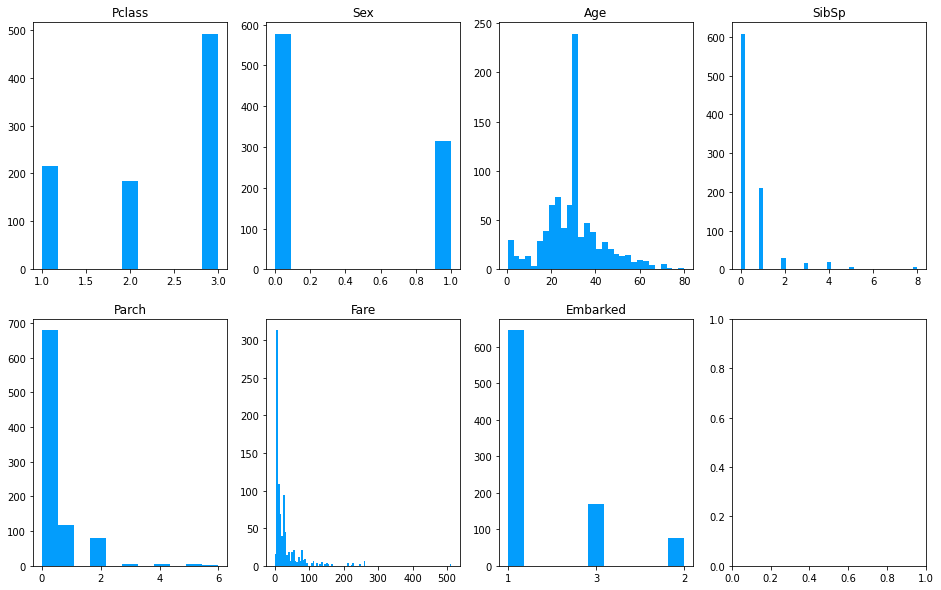

In [27]:
# Create histograms for feature columns
register_matplotlib_converters()
nrows = 2; ncols = int(round(x_df.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(16, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
columns = x_df.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        if f <= x_df.shape[1]-1:
            assetname = columns[f]
            y = x_df[assetname]
            ax[i, j].hist(y, color='#039dfc', label=assetname, bins='auto')
            f += 1
            ax[i, j].set_title(assetname)
plt.show()

# Split the Data into Train and Test

In [28]:
# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

# Train a single Random Forest Classification Model

([<matplotlib.axis.YTick at 0x2b6f8440288>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

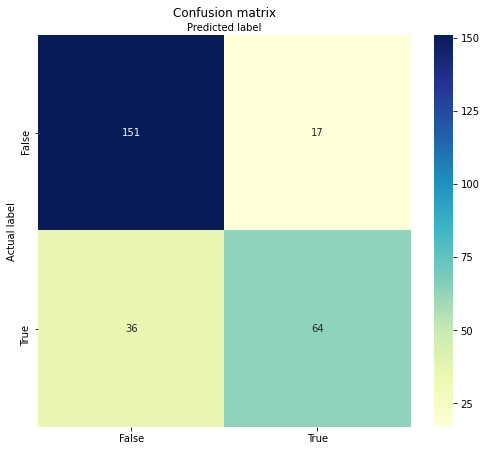

In [29]:
# Train a single random forest classifier - parameters are a best guess
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Hyper-parameter-tuning using Grid Search

In [30]:
# Define parameters
max_depth=[2, 8, 16]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the gridsearch
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.78651685 0.7929374  0.78651685 0.81219904 0.81380417 0.81701445
 0.78972713 0.78651685 0.78972713], using {'max_depth': 8, 'n_estimators': 256}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.042435,0.001654,0.004552,0.000501,2,64,"{'max_depth': 2, 'n_estimators': 64}",0.769841,0.800,0.798387,0.782258,0.782258,0.786517,0.011313,7
1,0.076831,0.003473,0.008225,0.000549,2,128,"{'max_depth': 2, 'n_estimators': 128}",0.793651,0.832,0.798387,0.758065,0.782258,0.792937,0.024019,4
2,0.144642,0.002168,0.013863,0.000613,2,256,"{'max_depth': 2, 'n_estimators': 256}",0.761905,0.832,0.782258,0.774194,0.782258,0.786517,0.023980,7
3,0.045710,0.001707,0.005377,0.000492,8,64,"{'max_depth': 8, 'n_estimators': 64}",0.777778,0.824,0.806452,0.806452,0.846774,0.812199,0.022774,3
4,0.090837,0.004765,0.008198,0.000388,8,128,"{'max_depth': 8, 'n_estimators': 128}",0.777778,0.824,0.806452,0.798387,0.862903,0.813804,0.028657,2
5,0.179845,0.010320,0.027877,0.024544,8,256,"{'max_depth': 8, 'n_estimators': 256}",0.777778,0.824,0.806452,0.814516,0.862903,0.817014,0.027636,1
6,0.051737,0.001309,0.005235,0.000372,16,64,"{'max_depth': 16, 'n_estimators': 64}",0.746032,0.800,0.790323,0.758065,0.854839,0.789727,0.038089,5
7,0.093542,0.002371,0.008786,0.000738,16,128,"{'max_depth': 16, 'n_estimators': 128}",0.753968,0.792,0.790323,0.758065,0.838710,0.786517,0.030438,7
8,0.203948,0.003449,0.017141,0.000381,16,256,"{'max_depth': 16, 'n_estimators': 256}",0.753968,0.824,0.766129,0.758065,0.846774,0.789727,0.038110,5


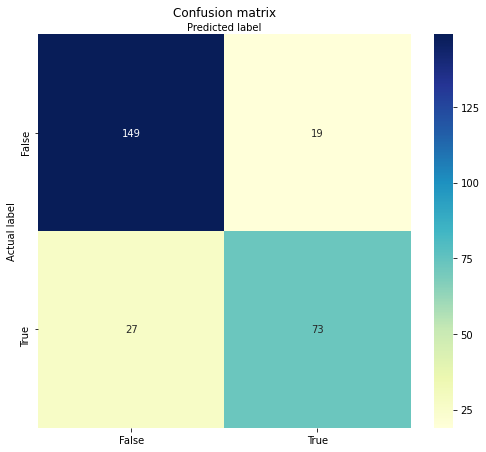

In [31]:
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
tick_marks = [0.5, 1.5]